In [1]:
from sklearn.datasets import load_diabetes
import pickle
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import os
import torch


from synthcity.metrics.eval_performance import (
    PerformanceEvaluatorMLP,
    PerformanceEvaluatorXGB,
)
from synthcity.utils import reproducibility
from synthcity.plugins import Plugins
import synthcity.logger as log
from synthcity.plugins.core.dataloader import GenericDataLoader
from DGE_utils import metric_different_datasets, mean_across_pandas, add_std, get_folder_names

reproducibility.clear_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


assert device.type == 'cuda'
Plugins(categories=["generic"]).list()


/home/bv292/miniconda/envs/gen/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.



['gaussian_copula',
 'adsgan',
 'dpgan',
 'copulagan',
 'tvae',
 'pategan',
 'rtvae',
 'privbayes',
 'nflow',
 'ctgan',
 'sdv_ctgan',
 'bayesian_network',
 'sdv_tvae']

In [2]:
from DGE_data import get_real_and_synthetic

# let's restrict ourselves to classification datasets
datasets = ['moons', 'circles', 'breast_cancer',
            'adult',  'seer', 'covid']
# ['moons', 'circles','cal_housing', 'adult', 'diabetes', 'breast_cancer',  'seer', 'cutract' ]
model_name = 'ctgan'  # synthetic data model

p_train = 0.8  # proportion of training data for generative model. Default values if None
n_models = 20  # number of models in ensemble, for each run
max_n = 2000  # maximum number of data points to use for training generative model.
nsyn = 2000  # number of synthetic data points per synthetic dataset. Defaults to same as generative training size if None

num_runs = 5  # Number of runs. Don't choose to large, since total number of synthetic datasets is num_runs*n_models

load = True  # results
load_syn = True  # data
save = True  # save results and data

outlier = False

verbose = False

if nsyn is None:
    nsyn = max_n


In [3]:
from DGE_utils import get_folder_names, tt_predict_performance, cat_dl
from DGE_data import get_real_and_synthetic
from DGE_experiments import cross_val
import pandas as pd
from sklearn.model_selection import KFold


In [28]:
num_runs = 5
model_type = 'deepish_mlp'
model_name = 'ctgan'
nsyn = 5000
max_n = 2000
p_train = 0.8
n_models = 20
cross_fold = 5
load_syn = True
load = True
save = True
verbose = True

scores_s_all = {}
scores_r_all = {}

datasets = ['moons', 'circles', 'adult', 'seer', 'covid']

for dataset in datasets[-3:]:
    workspace_folder, results_folder = get_folder_names(
        dataset, model_name, max_n=max_n, nsyn=nsyn)

    X_gt, X_syns = get_real_and_synthetic(dataset=dataset,
                                          p_train=p_train,
                                          n_models=n_models*num_runs,
                                          model_name=model_name,
                                          load_syn=load_syn,
                                          verbose=verbose,
                                          max_n=max_n,
                                          nsyn=nsyn)

    print(f'Dataset {dataset}\n')

    scores_s, scores_r = cross_val(X_gt,
                                  X_syns,
                                  workspace_folder=workspace_folder,
                                  results_folder=results_folder,
                                  save=save,
                                  load=load,
                                  task_type=model_type,
                                  cross_fold=cross_fold,
                                  verbose=verbose
                                  )

    scores_s_all[dataset] = scores_s
    scores_r_all[dataset] = scores_r


n_total 32561 n_train: 2000
Generating more data, existing dataset is smaller than nsyn
Training model 11/100


  4%|▍         | 82/2000 [00:11<04:24,  7.24it/s]


KeyboardInterrupt: 

adult


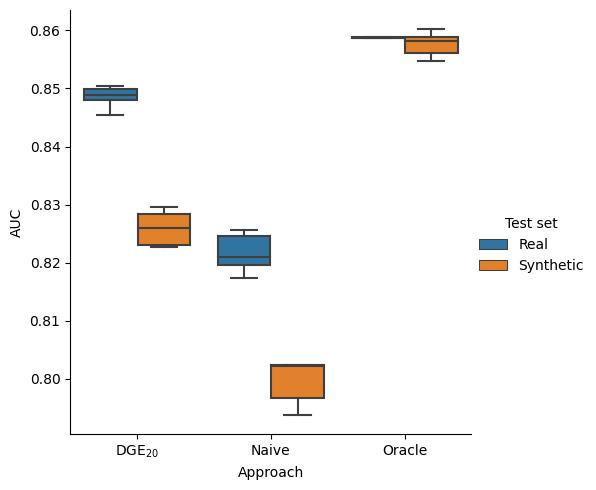

seer


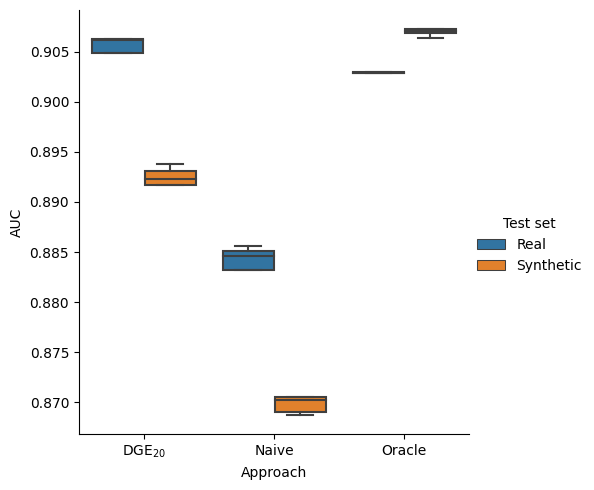

covid


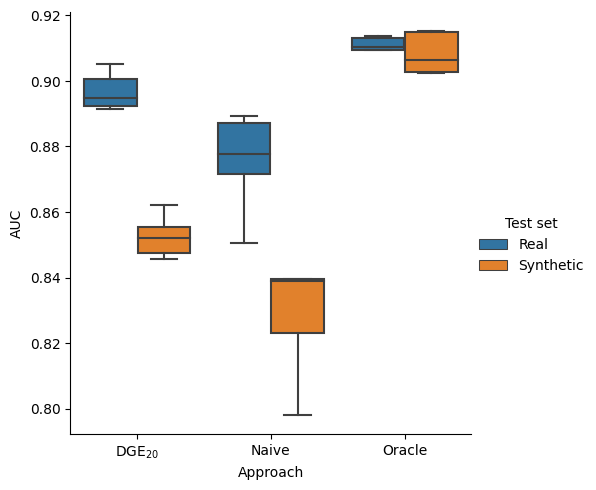

In [ ]:

metric = 'AUC'
import seaborn as sns
import matplotlib.pyplot as plt
for dataset in scores_s_all.keys():
    print(dataset)
    scores_r_all[dataset]['Test set'] = 'Real'
    scores_s_all[dataset]['Test set'] = 'Synthetic'
    scores_ = pd.concat([scores_r_all[dataset], scores_s_all[dataset]],axis=0)
    scores_.reset_index(inplace=True)
    scores_.rename(columns={'approach':'Approach'}, inplace=True)
    scores_ = scores_.mask(scores_ == 'DGE$_{20]$','DGE$_{20}$')
    scores_ = scores_.mask(scores_ == 'DGE$_{20}$ (concat)','Naive (C)')
    scores_ = scores_[scores_['Approach']!= 'Naive (C)']
    
    sns.catplot(data=scores_, x='Approach', y=metric, hue='Test set', kind='box', showfliers=False)
    os.makedirs(f'./uncertainty_results/cross_val/', exist_ok=True)
    plt.savefig(f'./uncertainty_results/cross_val/{dataset}_{metric}_{model_name}_nsyn_{nsyn}_maxn{max_n}_{model_type}.png')
    plt.show()


In [18]:
scores_

,run,approach,AUC,Acc,F1,Precision,Recall,NLL,Brier,split,Test set
0,0,DGE$_{20}$,0.831159,0.791604,0.587674,0.561490,0.616664,0.616449,0.154032,2.0,Real
1,0,Naive (C),0.831046,0.791771,0.585242,0.562844,0.610035,0.607388,0.153669,2.0,Real
2,0,Naive,0.822117,0.772359,0.580955,0.522042,0.655085,1.276371,0.195062,2.0,Real
3,0,Oracle,0.854638,0.808185,0.585053,0.611344,0.563508,1.110321,0.160851,2.0,Real
4,1,DGE$_{20}$,0.826744,0.790951,0.577712,0.563525,0.594546,0.625280,0.155704,2.0,Real
5,1,Naive (C),0.825924,0.789899,0.577422,0.560082,0.596414,0.627765,0.156067,2.0,Real
6,1,Naive,0.819998,0.773492,0.564851,0.527206,0.610728,1.166206,0.191408,2.0,Real
7,1,Oracle,0.859268,0.807409,0.602975,0.599567,0.607714,1.174600,0.163498,2.0,Real
8,2,DGE$_{20}$,0.829623,0.794013,0.581487,0.569700,0.594305,0.608923,0.151775,2.0,Real
9,2,Naive (C),0.829898,0.794441,0.581110,0.570995,0.592225,0.612386,0.152412,2.0,Real
